# Case Study 1

#### Model selection for Clustering

Clustering is unsupervised learning: the resulting clusters are completely derived from data distributed in given a feature set with no class available

Compared to supervised learning counterparts, it is …
* hard to define model performance (cluster quality)
* sensitive to different clustering algorithms and different feature spaces.



#### Task
Your task is to try different clustering algorithms and also a range of the potential parameter(s) which affect the number of clusters including ..

* K-means
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* Gaussian Mixture Model,
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
* Hierarchical Clustering,
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
* Louvain Clustering,
https://scikit-network.readthedocs.io/en/latest/reference/clustering.html#module-sknetwork.clustering

on 5K colorectal patches represented by 4 different representation PathologyGAN, ResNet50, InceptionV3 and VGG16


#### Data and its preprocessing
5,000 non-overlapping image patches from hematoxylin & eosin (H&E) stained histological images of human colorectal cancer (CRC) and normal tissue.
* 4 feature sets, PathologyGAN, ResNet50, InceptionV3 and VGG16, are extracted to represent those 5,000 images different dimensional feature spaces.
* PCA and UMAP were employed to reduce each feature sapce into 100-dimensional vectors

* 9 tissue types are also available which include Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM)


#### Performance Measurement
To assess quality of clustering solutions, several approaches are expected to be done and interpreted which include...
* Silhouette Score for goodness of fit test
* Vmeasure Score for homogeneity and completeness test (tissue type available as ground truth)
* Clusters visualisations

For more information, please have a check...
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation


#### Report
Report on your preprocessing pipeline, theory and intuition behinds each algorithm and representation, parameter searching and performance evaluation frameworks. If there is any addiotional process, give evidences/justifications on how it helps.

#### Required Packages

In [1]:
# !pip install h5py
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install scikit-network
# !pip install pickle-mixin==1.0.2
# !pip install matplotlib
# !pip install plotly


### Prepare Tissue Representations

Model, resnet50, pathologyGAN
Projection PCA, UMAP
Method KMeans, Louvain

Data            Metric
Test            Sihouette + Davies-Bouldin Index ==> need to Cross Validate to get good parameters
Label?          V-measure + Rand Index ==> show performance(model?), show similarity to test ones if YES -> we did use good parameters there

Parameters
1. k (number of cluster)

In [2]:
import h5py
import numpy as np
import pickle

In [3]:
pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = 'colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')


In [4]:
vgg16_content

<HDF5 file "vgg16_dim_reduced_feature.h5" (mode r)>

In [5]:
#PCA feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]
inceptionv3_pca_feature = inceptionv3_content['pca_feature'][...]
vgg16_pca_feature  = vgg16_content['pca_feature'][...]

In [6]:
vgg16_pca_feature

array([[ -90.864815 ,  107.03243  ,  116.16385  , ...,    8.259951 ,
          -1.1383446,   -9.175951 ],
       [ -74.06226  ,  117.31615  ,   95.24547  , ...,   -1.9739974,
           6.8172655,    4.2547903],
       [ -81.875336 ,  122.84872  ,   83.767784 , ...,   -1.3287221,
          13.65623  ,  -11.109545 ],
       ...,
       [  32.70835  ,   31.183935 ,  -47.30978  , ...,    4.2004256,
           3.599823 ,    6.0058775],
       [ -39.911785 , -105.81029  ,  122.37118  , ...,  -14.908715 ,
          -1.1814455,  -10.837135 ],
       [  32.35425  ,  -50.3373   ,   66.50197  , ...,   -3.859397 ,
          -1.047523 ,    2.3827858]], dtype=float32)

In [7]:
#UMAP feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_umap_feature  = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]
inceptionv3_umap_feature  = inceptionv3_content['umap_feature'][...]
vgg16_umap_feature  = vgg16_content['umap_feature'][...]

In [8]:
#tissue type as available ground-truth: labels
filename  = np.squeeze(pge_content['file_name'])
filename = np.array([str(x) for x in filename])
labels = np.array([x.split('/')[2] for x in filename])
labels

array(['ADI', 'ADI', 'ADI', ..., 'TUM', 'TUM', 'TUM'], dtype='<U4')

# Example

In [9]:
import random

In [10]:
random.seed(0)
selected_index = random.sample(list(np.arange(len(pge_pca_feature))), 200)

In [11]:
test_data = pge_pca_feature[selected_index]
test_label = labels[selected_index]

### Exploratory Analysis

In [12]:
import plotly.graph_objects as go
import pandas as pd

In [13]:
traces = []
for name in np.unique(labels):
    trace = go.Scatter3d(
        x=test_data[test_label==name,0],
        y=test_data[test_label==name,1],
        z=test_data[test_label==name,2],
        mode='markers',
        name=name,
        marker=go.scatter3d.Marker(
            size=4,
            opacity=0.8
        )

    )
    traces.append(trace)


data = go.Data(traces)
layout = go.Layout(
            showlegend=True,
    scene=go.Scene(
                xaxis=go.layout.scene.XAxis(title='PC1'),
                yaxis=go.layout.scene.YAxis(title='PC2'),
                zaxis=go.layout.scene.ZAxis(title='PC3')
                )
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    title="First 3 pricipal components of PathologyGAN's PCA feature",
    legend_title="Legend Title",
)

fig.show()


/Users/jojotitichaya/Downloads/case_study_1/venv/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning: plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.

  warnings.warn(
/Users/jojotitichaya/Downloads/case_study_1/venv/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:489: DeprecationWarning: plotly.graph_objs.Scene is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Scene

  warnings.warn(


### Model training

In [14]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sknetwork.clustering import Louvain


In [15]:
#to create Adjacency matrix for  Louvain clustering
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler


In [16]:
kmeans_model = KMeans(n_clusters = 3, random_state = 0) #GaussianMixture(), AgglomerativeClustering(), Louvain
kmeans_assignment = kmeans_model.fit_predict(test_data)

/Users/jojotitichaya/Downloads/case_study_1/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [17]:
from scipy import sparse
louvain_model = Louvain(resolution = 0.9, modularity = 'Newman',random_state = 0)
adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(test_data)))
louvain_assignment = louvain_model.fit_predict(adjacency_matrix)

### Evaluation and Visualisation

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.model_selection import KFold, train_test_split

* check out number of clusters/cluster assignment counts

In [19]:
print('Number of clusters from KMeans: %d and from Louvain: %d'%(np.unique(kmeans_assignment).shape[0],np.unique(louvain_assignment).shape[0]))

Number of clusters from KMeans: 3 and from Louvain: 3


In [20]:
kmeans_counts = np.unique(kmeans_assignment, return_counts = True)
louvain_counts = np.unique(louvain_assignment, return_counts = True)

In [21]:
print('Kmeans assignment counts')
pd.DataFrame({'Cluster Index': kmeans_counts[0], 'Number of members':kmeans_counts[1]}).set_index('Cluster Index')

Kmeans assignment counts


,Number of members
Cluster Index,
0,112
1,49
2,39


In [22]:
print('Louvain assignment counts')
pd.DataFrame({'Cluster Index': louvain_counts[0], 'Number of members':louvain_counts[1]}).set_index('Cluster Index')

Louvain assignment counts


,Number of members
Cluster Index,
0,132
1,67
2,1


* Assess goodness of fit by silhouette score and cluster homogeneities by V-measure

In [23]:
kmeans_silhouette = silhouette_score(test_data, kmeans_assignment)
louvain_silhouette = silhouette_score(test_data, louvain_assignment)
kmeans_v_measure = v_measure_score(test_label, kmeans_assignment)
louvain_v_measure = v_measure_score(test_label, louvain_assignment)
pd.DataFrame({'Metrics': ['silhouette', 'V-measure'], 'Kmeans': [kmeans_silhouette, kmeans_v_measure], 'Louvain':[louvain_silhouette, louvain_v_measure]}).set_index('Metrics')

,Kmeans,Louvain
Metrics,,
silhouette,0.198873,0.246675
V-measure,0.262987,0.270140


* Visualise tissue type percentage in two different clustering configurations

In [24]:
def calculate_percent(sub_df, attrib):
    cnt = sub_df[attrib].count()
    output_sub_df = sub_df.groupby(attrib).count()
    return (output_sub_df/cnt)

/var/folders/pv/_9ndz20s1819l5gdqpjk79240000gn/T/ipykernel_63195/3428919821.py:27: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



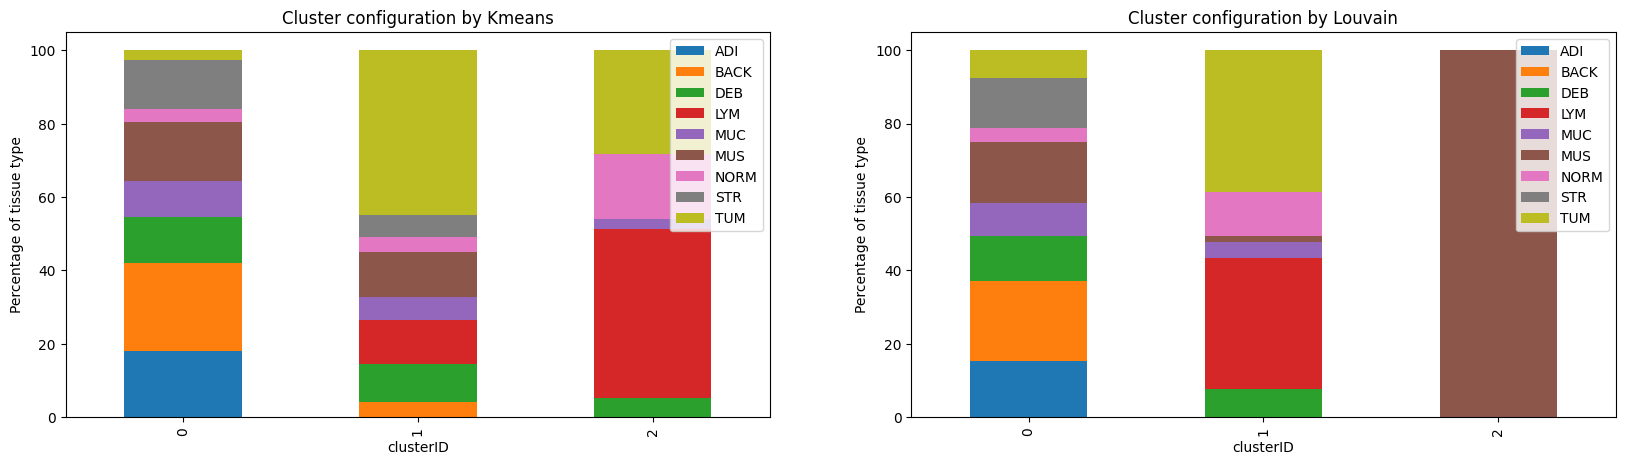

In [25]:
resulted_cluster_df = pd.DataFrame({'clusterID': kmeans_assignment, 'type': test_label})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans')

resulted_cluster_df = pd.DataFrame({'clusterID': louvain_assignment, 'type': test_label})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Louvain')
f.show()

# Preparing the dataset for PathologyGAN (PGE) and ResNet50



In [26]:
#PCA feature from 2 feature sets: pge_latent, resnet50_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]

#UMAP feature from 2 feature sets: pge_latent, resnet50_latent
pge_umap_feature  = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]

#PGE test data
test_data_pge_pca = pge_pca_feature
test_data_pge_umap = pge_umap_feature

#PGE labels
filename_pge  = np.squeeze(pge_content['file_name'])
filename_pge = np.array([str(x) for x in filename_pge])
labels_pge = np.array([x.split('/')[2] for x in filename_pge])

#Resnet50 test data
test_data_resnet50_pca = resnet50_pca_feature
test_data_resnet50_umap = resnet50_umap_feature

#Resnet50 labels
filename_resnet50 = np.squeeze(resnet50_content['file_name'])
filename_resnet50 = np.array([str(x) for x in filename_resnet50])
labels_resnet50 = np.array([x.split('/')[2] for x in filename_resnet50])

# K-Means Clustering

Training the model using N=2...30 to find the optimal number of cluster using the Elbow method.

In [27]:
from sklearn.cluster import KMeans
from sknetwork.clustering import get_modularity

In [28]:
def train_squared_KMeans(test_data, k_max = 30, sum_list = [], ylabel = 'PCA', xlabel = 'PGE'):
  K = list(range(2,k_max))
  
  for k in K:
      km = KMeans(k)
      km_fitted = km.fit(test_data)
      sum_list.append(km_fitted.inertia_)

def train_squared(test_data, sum_list = [], ylabel = 'PCA', xlabel = 'PGE', Model=KMeans, **param):
  
  if Model is KMeans:
    K = list(range(2, param['n_clusters']))

    for k in K:
      model = Model(n_clusters=k, n_init=10)
      model_fitted = model.fit(test_data)
      sum_list.append([k,model_fitted.inertia_])
      # print(sum_list)

  elif Model is AgglomerativeClustering:
    # print(param)
    K = list(range(2,param['n_clusters']))
    
    for k in K:
      model = Model(n_clusters=k, metric=param['affinity'], linkage=param['linkage'])
      model_fitted = model.fit_predict(test_data)
      sum_list.append([k,silhouette_score(test_data, model_fitted)])

  elif Model is Louvain:
    K = np.arange(0.9, 1.1, 0.025)
    for r in K:
      # print(r)
      louvain_model = Louvain(resolution = r)
      adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(test_data)))
      louvain_assignment = louvain_model.fit_predict(adjacency_matrix)
      louvain_counts = np.unique(louvain_assignment, return_counts = True)
      # modularity_score = louvain_model
      modularity_score = get_modularity(adjacency_matrix, louvain_assignment)

      ##append score of louvain
      sum_list.append([r,modularity_score])
    # print(sum_list)
  plt.plot(K, [i[1] for i in sum_list], 'bo-')
  plt.xlabel('k')
  plt.ylabel(f'sum_of_squared_distances {ylabel}')
  plt.title(f'Elbow Method For Optimal k using {xlabel}')
  plt.show()

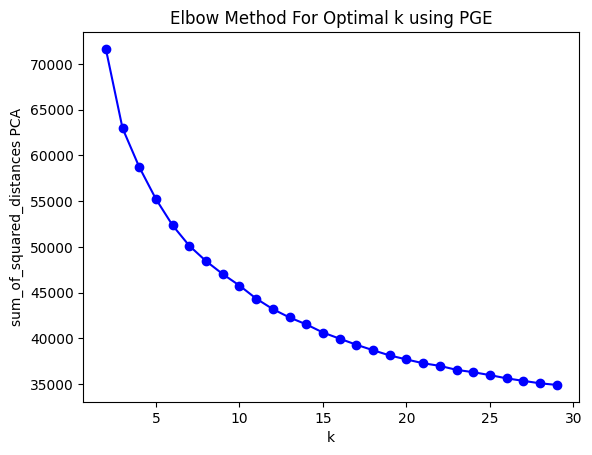

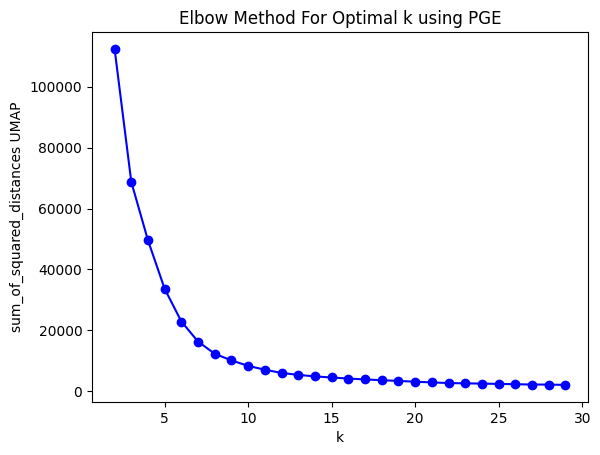

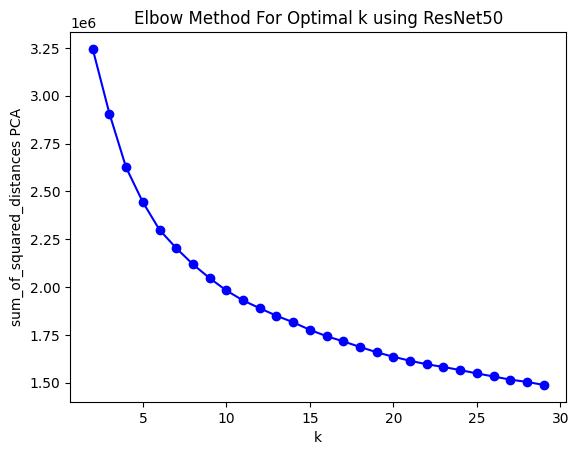

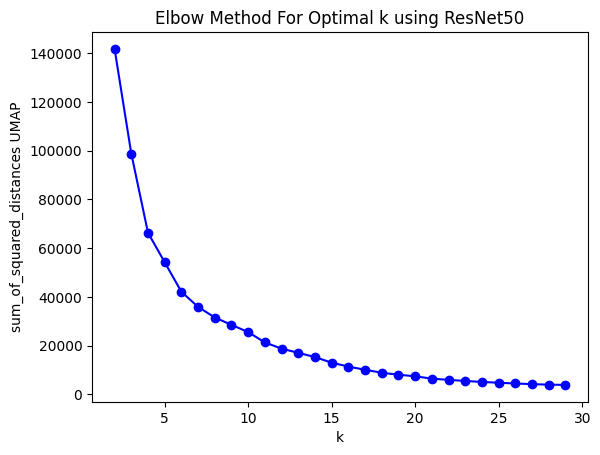

In [29]:
# KMeans PGE
pge_pca_kmean_score = [] # PCA
pge_umap_kmean_score = [] # UMAP

# KMeans ResNet50
resnet_pca_kmean_score = [] # PCA
resnet_umap_kmean_score = [] # UMAP

# Kmean
train_squared(test_data_pge_pca, pge_pca_kmean_score, 'PCA', 'PGE', KMeans, n_clusters=30) # PGE PCA
train_squared(test_data_pge_umap, pge_umap_kmean_score, 'UMAP', 'PGE', KMeans, n_clusters=30) # PGE UMAP

train_squared(test_data_resnet50_pca, resnet_pca_kmean_score, 'PCA', 'ResNet50', KMeans, n_clusters=30) # ResNet50 PCA
train_squared(test_data_resnet50_umap, resnet_umap_kmean_score, 'UMAP', 'ResNet50', KMeans, n_clusters=30) # ResNet50 UMAP

In [30]:
x = [[2, 71638.78125], [3, 62970.86328125], [4, 58730.2578125]]
print(*x)

[2, 71638.78125] [3, 62970.86328125] [4, 58730.2578125]


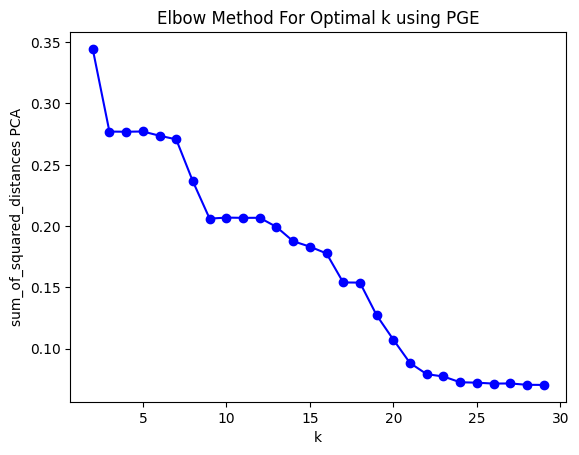

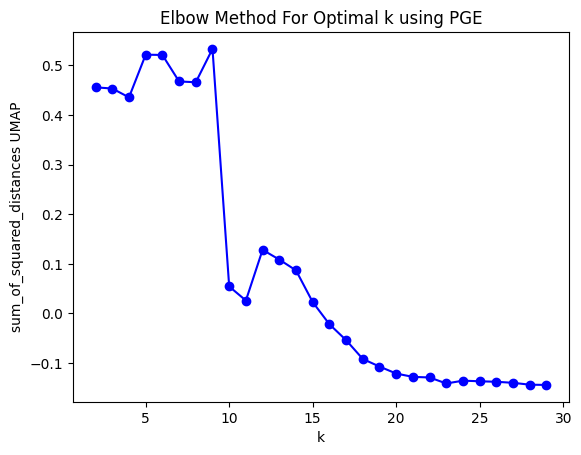

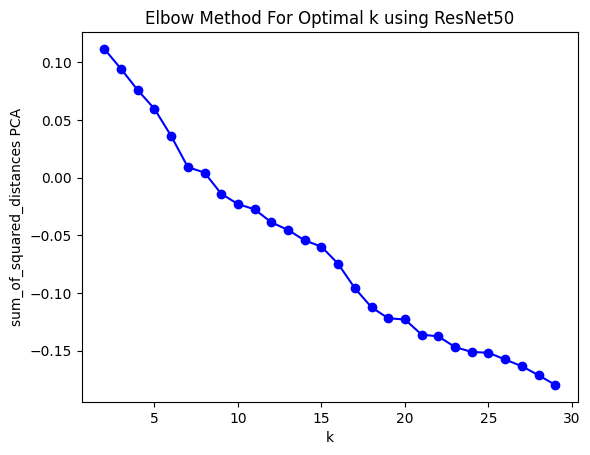

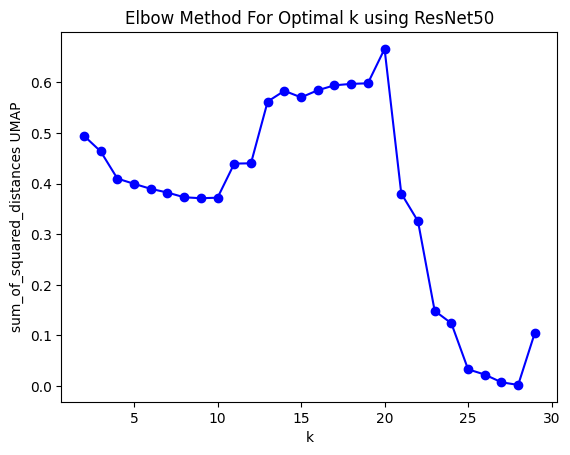

In [31]:
# Hierarchical PGE
pge_pca_hier_score = [] # PCA
pge_umap_hier_score = [] # UMAP

# Hierarchical ResNet50
resnet_pca_hier_score = [] # PCA
resnet_umap_hier_score = [] # UMAP

# Hierarchical
train_squared(test_data_pge_pca, pge_pca_hier_score, 'PCA', 'PGE', AgglomerativeClustering, n_clusters=30, affinity='euclidean', linkage='single') # PGE PCA
train_squared(test_data_pge_umap, pge_umap_hier_score, 'UMAP', 'PGE', AgglomerativeClustering, n_clusters=30, affinity='euclidean', linkage='single') # PGE UMAP

train_squared(test_data_resnet50_pca, resnet_pca_hier_score, 'PCA', 'ResNet50', AgglomerativeClustering, n_clusters=30, affinity='euclidean', linkage='single') # ResNet50 PCA
train_squared(test_data_resnet50_umap, resnet_umap_hier_score, 'UMAP', 'ResNet50', AgglomerativeClustering, n_clusters=30, affinity='euclidean', linkage='single') # ResNet50 UMAP


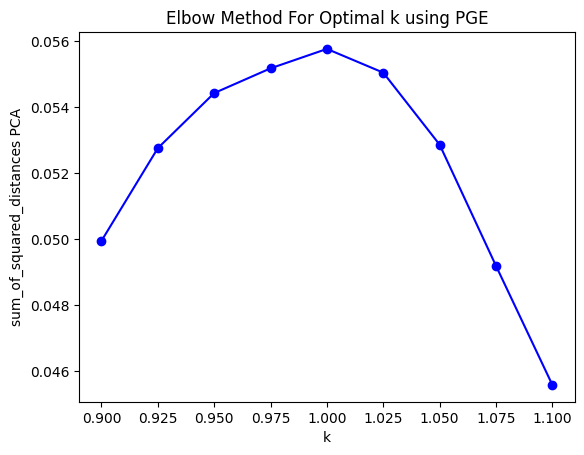

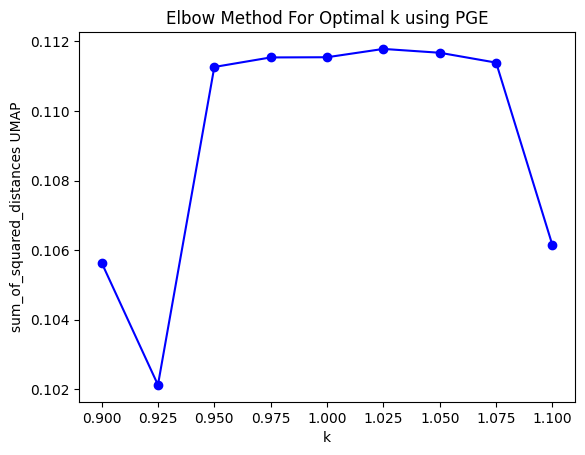

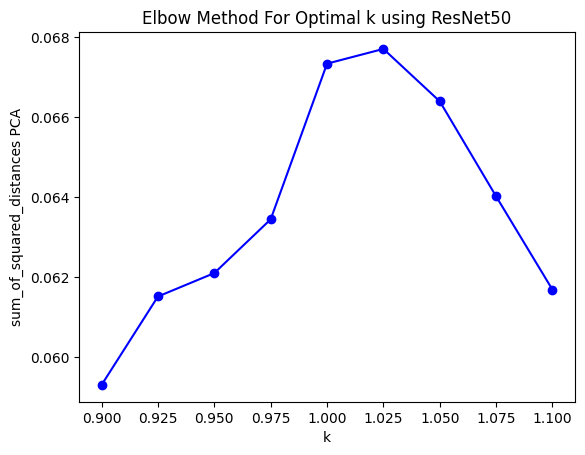

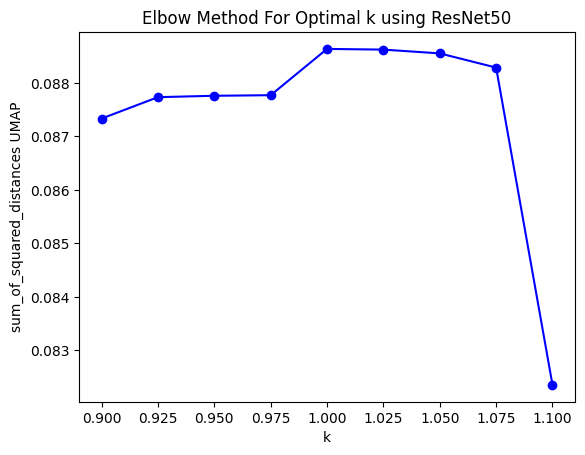

In [32]:
# Louvain PGE
pge_pca_louvain_score = [] # PCA
pge_umap_louvain_score = [] # UMAP

# Louvain ResNet50
resnet_pca_louvain_score = [] # PCA
resnet_umap_louvain_score = [] # UMAP

# Louvain
train_squared(test_data_pge_pca, pge_pca_louvain_score, 'PCA', 'PGE', Louvain) # PGE PCA
train_squared(test_data_pge_umap, pge_umap_louvain_score, 'UMAP', 'PGE', Louvain) # PGE UMAP

train_squared(test_data_resnet50_pca, resnet_pca_louvain_score, 'PCA', 'ResNet50', Louvain) # ResNet50 PCA
train_squared(test_data_resnet50_umap, resnet_umap_louvain_score, 'UMAP', 'ResNet50', Louvain) # ResNet50 UMAP

## Evaluation and Visualizing

We can observe from the above graphs that it is difficult to derive the exact k value using only the Elbow method from the curve. Hence, to get a better measurement, we are also calculating the silhouette score and v-measure to obtain the best k-value for both the feature sets.

Assuming the ground truth labels are not present, we are finding the 'k' using sillhouete score to find which 'k' perfectly fits the data.

### Intrinsic Measures

In [33]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from sklearn.preprocessing import MinMaxScaler

def kMeansRes(scaled_data, k, alpha_k=0.02):
    '''
    Parameters 
    ----------
    scaled_data: matrix 
        scaled data. rows are samples and columns are features for clustering
    k: int
        current k for applying KMeans
    alpha_k: float
        manually tuned factor that gives penalty to the number of clusters
    Returns 
    -------
    scaled_inertia: float
        scaled inertia value for current k           
    '''
    
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    # fit k-means
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kMeansRes(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

def get_best_kmean(data_for_clustering):
    # create data matrix
    data_matrix = np.matrix(data_for_clustering).astype(float)
    # scale the data
    mms = MinMaxScaler()
    scaled_data = mms.fit_transform(np.asarray(data_matrix))

    # choose k range
    k_range=range(2,20)
    # compute adjusted intertia
    best_k, results = chooseBestKforKMeans(scaled_data, k_range)
    # plot the results
    print('Best k',best_k)
    plt.figure(figsize=(7,4))
    plt.plot(results,'o')
    plt.title('Adjusted Inertia for each K')
    plt.xlabel('K')
    plt.ylabel('Adjusted Inertia')
    plt.xticks(range(2,20,1))
    return best_k

In [34]:
def get_best(score_list):
    k = [i[0] for i in score_list]
    value = [i[1] for i in score_list]
    return k[value.index(max(value))]


/var/folders/pv/_9ndz20s1819l5gdqpjk79240000gn/T/ipykernel_63195/897820884.py:35: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Best k 2


/var/folders/pv/_9ndz20s1819l5gdqpjk79240000gn/T/ipykernel_63195/897820884.py:35: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Best k 11


/var/folders/pv/_9ndz20s1819l5gdqpjk79240000gn/T/ipykernel_63195/897820884.py:35: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Best k 2
Best k 12


/var/folders/pv/_9ndz20s1819l5gdqpjk79240000gn/T/ipykernel_63195/897820884.py:35: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



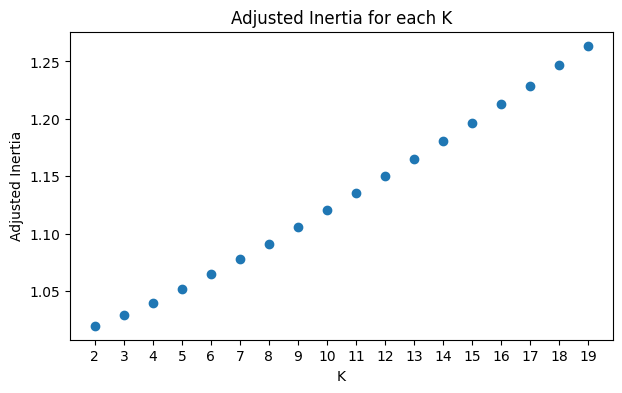

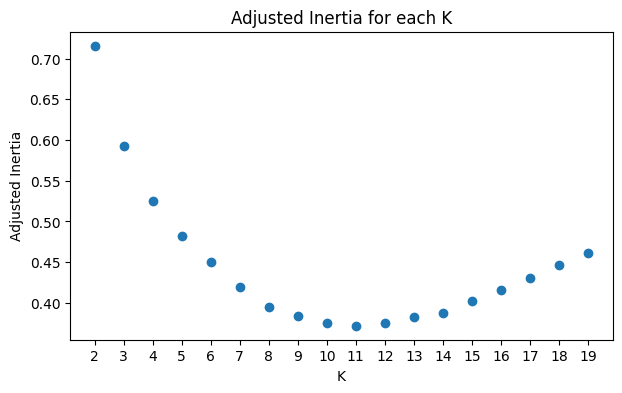

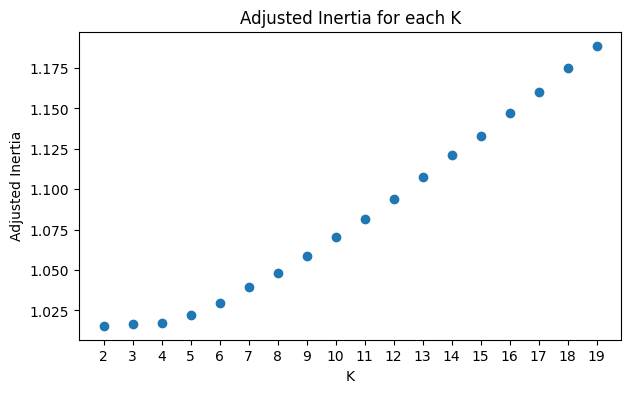

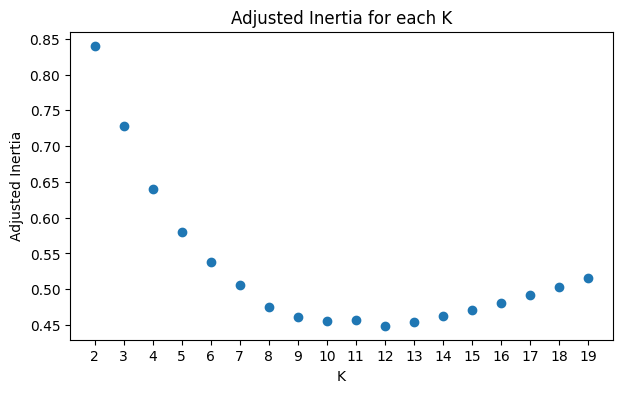

In [35]:
best_k_pge_pca_kmean = get_best_kmean(test_data_pge_pca)
best_k_pge_umap_kmean = get_best_kmean(test_data_pge_umap)

best_k_resnet_pca_kmean = get_best_kmean(test_data_resnet50_pca)
best_k_resnet_umap_kmean = get_best_kmean(test_data_resnet50_umap)


best_k_pge_pca_hier = get_best(pge_pca_hier_score)
best_k_pge_umap_hier = get_best(pge_umap_hier_score)

best_k_resnet_pca_hier = get_best(resnet_pca_hier_score)
best_k_resnet_umap_hier = get_best(resnet_umap_hier_score)


best_r_pge_pca_louvain = get_best(pge_pca_louvain_score)
best_r_pge_umap_louvain = get_best(pge_umap_louvain_score)

best_r_resnet_pca_louvain = get_best(resnet_pca_louvain_score)
best_r_resnet_umap_louvain = get_best(resnet_umap_louvain_score)


After using an equation to automatical determine the most suitable number of cluster for KMeans clustering algorithm its seems to be a conflict between manual and automate of PCA test data ones, while we our best k is exactly the same to automate ones of UMAP but PCA. In other word, we agreed that PCA data relationships can't be distinguish by KMeans clustering algorithm. Nevertheless, we considered to keep going with our manual consideration for best k cluster number.

In [36]:
best_k_pge_pca_kmean = 14

best_k_resnet_pca_kmean = 13

#### Silhouette Coefficient

In [62]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import rand_score
def metric_calculation(metric,test_data, best_param = 2, Model=KMeans, **param):  

    if Model is KMeans:
        model = Model(n_clusters=best_param, n_init=10)
        model_fitted = model.fit_predict(test_data)

    elif Model is AgglomerativeClustering:
        model = Model(n_clusters=best_param, metric='euclidean', linkage='single')
        model_fitted = model.fit_predict(test_data)

    elif Model is Louvain:
        louvain_model = Louvain(resolution = best_param)
        adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(test_data)))
        model_fitted = louvain_model.fit_predict(adjacency_matrix)

    if metric == 'silhouette':
        return silhouette_score(test_data, model_fitted)
    elif metric == 'davies':
        return davies_bouldin_score(test_data, model_fitted)
    elif metric == 'rand_pge':
        return rand_score(labels_pge, model_fitted)
    elif metric == 'rand_resnet':
        return rand_score(labels_resnet50, model_fitted)
    elif metric == 'v_measure_pge':
        return v_measure_score(labels_pge, model_fitted)
    elif metric == 'v_measure_resnet':
        return v_measure_score(labels_resnet50, model_fitted)
        
    

In [38]:
# PGE
silhouette_scores_pca_pge_kmeans = metric_calculation('silhouette', test_data_pge_pca,best_k_pge_pca_kmean,Model=KMeans)
silhouette_scores_pca_pge_hier = metric_calculation('silhouette', test_data_pge_pca,best_k_pge_pca_hier,Model=AgglomerativeClustering)
silhouette_scores_pca_pge_louvain = metric_calculation('silhouette', test_data_pge_pca,best_r_pge_pca_louvain,Model=Louvain)

silhouette_scores_umap_pge_kmeans = metric_calculation('silhouette', test_data_pge_umap,best_k_pge_umap_kmean,Model=KMeans)
silhouette_scores_umap_pge_hier = metric_calculation('silhouette', test_data_pge_umap,best_k_pge_umap_hier,Model=AgglomerativeClustering)
silhouette_scores_umap_pge_louvain = metric_calculation('silhouette', test_data_pge_umap,best_r_pge_umap_louvain,Model=Louvain)


# ResNet50
silhouette_scores_pca_resnet_kmeans = metric_calculation('silhouette', test_data_resnet50_pca,best_k_resnet_pca_kmean,Model=KMeans)
silhouette_scores_pca_resnet_hier = metric_calculation('silhouette', test_data_resnet50_pca,best_k_resnet_pca_hier,Model=AgglomerativeClustering)
silhouette_scores_pca_resnet_louvain = metric_calculation('silhouette', test_data_resnet50_pca,best_r_resnet_pca_louvain,Model=Louvain)

silhouette_scores_umap_resnet_kmeans = metric_calculation('silhouette', test_data_resnet50_umap,best_k_resnet_umap_kmean,Model=KMeans)
silhouette_scores_umap_resnet_hier = metric_calculation('silhouette', test_data_resnet50_umap,best_k_resnet_umap_hier,Model=AgglomerativeClustering)
silhouette_scores_umap_resnet_louvain = metric_calculation('silhouette', test_data_resnet50_umap,best_r_resnet_umap_louvain,Model=Louvain)


In [39]:
print("Silhouette Scores for PCA on PGE with KMeans:", silhouette_scores_pca_pge_kmeans)
print("Silhouette Scores for PCA on PGE with Hierarchical:", silhouette_scores_pca_pge_hier)
print("Silhouette Scores for PCA on PGE with Louvain:", silhouette_scores_pca_pge_louvain)

print("Silhouette Scores for UMAP on PGE with KMeans:", silhouette_scores_umap_pge_kmeans)
print("Silhouette Scores for UMAP on PGE with Hierarchical:", silhouette_scores_umap_pge_hier)
print("Silhouette Scores for UMAP on PGE with Louvain:", silhouette_scores_umap_pge_louvain)

print("Silhouette Scores for PCA on ResNet50 with KMeans:", silhouette_scores_pca_resnet_kmeans)
print("Silhouette Scores for PCA on ResNet50 with Hierarchical:", silhouette_scores_pca_resnet_hier)
print("Silhouette Scores for PCA on ResNet50 with Louvain:", silhouette_scores_pca_resnet_louvain)

print("Silhouette Scores for UMAP on ResNet50 with KMeans:", silhouette_scores_umap_resnet_kmeans)
print("Silhouette Scores for UMAP on ResNet50 with Hierarchical:", silhouette_scores_umap_resnet_hier)
print("Silhouette Scores for UMAP on ResNet50 with Louvain:", silhouette_scores_umap_resnet_louvain)

Silhouette Scores for PCA on PGE with KMeans: 0.12748174
Silhouette Scores for PCA on PGE with Hierarchical: 0.34450808
Silhouette Scores for PCA on PGE with Louvain: 0.09189911
Silhouette Scores for UMAP on PGE with KMeans: 0.55015314
Silhouette Scores for UMAP on PGE with Hierarchical: 0.5333726
Silhouette Scores for UMAP on PGE with Louvain: 0.49278057
Silhouette Scores for PCA on ResNet50 with KMeans: 0.13965847
Silhouette Scores for PCA on ResNet50 with Hierarchical: 0.111403994
Silhouette Scores for PCA on ResNet50 with Louvain: 0.014929112
Silhouette Scores for UMAP on ResNet50 with KMeans: 0.53337353
Silhouette Scores for UMAP on ResNet50 with Hierarchical: 0.6662179
Silhouette Scores for UMAP on ResNet50 with Louvain: 0.37299815


#### Devies-Bouldin Index

In [50]:
# PGE
davies_scores_pca_pge_kmeans = metric_calculation('davies', test_data_pge_pca,best_k_pge_pca_kmean,Model=KMeans)
davies_scores_pca_pge_hier = metric_calculation('davies', test_data_pge_pca,best_k_pge_pca_hier,Model=AgglomerativeClustering)
davies_scores_pca_pge_louvain = metric_calculation('davies', test_data_pge_pca,best_r_pge_pca_louvain,Model=Louvain)

davies_scores_umap_pge_kmeans = metric_calculation('davies', test_data_pge_umap,best_k_pge_umap_kmean,Model=KMeans)
davies_scores_umap_pge_hier = metric_calculation('davies', test_data_pge_umap,best_k_pge_umap_hier,Model=AgglomerativeClustering)
davies_scores_umap_pge_louvain = metric_calculation('davies', test_data_pge_umap,best_r_pge_umap_louvain,Model=Louvain)


# ResNet50
davies_scores_pca_resnet_kmeans = metric_calculation('davies', test_data_resnet50_pca,best_k_resnet_pca_kmean,Model=KMeans)
davies_scores_pca_resnet_hier = metric_calculation('davies', test_data_resnet50_pca,best_k_resnet_pca_hier,Model=AgglomerativeClustering)
davies_scores_pca_resnet_louvain = metric_calculation('davies', test_data_resnet50_pca,best_r_resnet_pca_louvain,Model=Louvain)

davies_scores_umap_resnet_kmeans = metric_calculation('davies', test_data_resnet50_umap,best_k_resnet_umap_kmean,Model=KMeans)
davies_scores_umap_resnet_hier = metric_calculation('davies', test_data_resnet50_umap,best_k_resnet_umap_hier,Model=AgglomerativeClustering)
davies_scores_umap_resnet_louvain = metric_calculation('davies', test_data_resnet50_umap,best_r_resnet_umap_louvain,Model=Louvain)


In [41]:
print("Davies Scores for PCA on PGE with KMeans:", davies_scores_pca_pge_kmeans)
print("Davies Scores for PCA on PGE with Hierarchical:", davies_scores_pca_pge_hier)
print("Davies Scores for PCA on PGE with Louvain:", davies_scores_pca_pge_louvain)

print("Davies Scores for UMAP on PGE with KMeans:", davies_scores_umap_pge_kmeans)
print("Davies Scores for UMAP on PGE with Hierarchical:", davies_scores_umap_pge_hier)
print("Davies Scores for UMAP on PGE with Louvain:", davies_scores_umap_pge_louvain)

print("Davies Scores for PCA on ResNet50 with KMeans:", davies_scores_pca_resnet_kmeans)
print("Davies Scores for PCA on ResNet50 with Hierarchical:", davies_scores_pca_resnet_hier)
print("Davies Scores for PCA on ResNet50 with Louvain:", davies_scores_pca_resnet_louvain)

print("Davies Scores for UMAP on ResNet50 with KMeans:", davies_scores_umap_resnet_kmeans)
print("Davies Scores for UMAP on ResNet50 with Hierarchical:", davies_scores_umap_resnet_hier)
print("Davies Scores for UMAP on ResNet50 with Louvain:", davies_scores_umap_resnet_louvain)


Davies Scores for PCA on PGE with KMeans: 1.8624599891413245
Davies Scores for PCA on PGE with Hierarchical: 0.7417079047182548
Davies Scores for PCA on PGE with Louvain: 1.935035512835478
Davies Scores for UMAP on PGE with KMeans: 0.5883970121605854
Davies Scores for UMAP on PGE with Hierarchical: 0.36959168927130875
Davies Scores for UMAP on PGE with Louvain: 0.7100678006876513
Davies Scores for PCA on ResNet50 with KMeans: 1.999679671435543
Davies Scores for PCA on ResNet50 with Hierarchical: 0.8077925909242978
Davies Scores for PCA on ResNet50 with Louvain: 2.401859511763125
Davies Scores for UMAP on ResNet50 with KMeans: 0.5626714654103139
Davies Scores for UMAP on ResNet50 with Hierarchical: 0.28590703874579926
Davies Scores for UMAP on ResNet50 with Louvain: 0.8305795184667881


### Extrinsic Measures

#### Rand Index

In [60]:
# PGE
rand_scores_pca_pge_kmeans = metric_calculation('rand_pge', test_data_pge_pca,best_k_pge_pca_kmean,Model=KMeans)
rand_scores_pca_pge_hier = metric_calculation('rand_pge', test_data_pge_pca,best_k_pge_pca_hier,Model=AgglomerativeClustering)
rand_scores_pca_pge_louvain = metric_calculation('rand_pge', test_data_pge_pca,best_r_pge_pca_louvain,Model=Louvain)

rand_scores_umap_pge_kmeans = metric_calculation('rand_pge', test_data_pge_umap,best_k_pge_umap_kmean,Model=KMeans)
rand_scores_umap_pge_hier = metric_calculation('rand_pge', test_data_pge_umap,best_k_pge_umap_hier,Model=AgglomerativeClustering)
rand_scores_umap_pge_louvain = metric_calculation('rand_pge', test_data_pge_umap,best_r_pge_umap_louvain,Model=Louvain)


# ResNet50
rand_scores_pca_resnet_kmeans = metric_calculation('rand_resnet', test_data_resnet50_pca,best_k_resnet_pca_kmean,Model=KMeans)
rand_scores_pca_resnet_hier = metric_calculation('rand_resnet', test_data_resnet50_pca,best_k_resnet_pca_hier,Model=AgglomerativeClustering)
rand_scores_pca_resnet_louvain = metric_calculation('rand_resnet', test_data_resnet50_pca,best_r_resnet_pca_louvain,Model=Louvain)

rand_scores_umap_resnet_kmeans = metric_calculation('rand_resnet', test_data_resnet50_umap,best_k_resnet_umap_kmean,Model=KMeans)
rand_scores_umap_resnet_hier = metric_calculation('rand_resnet', test_data_resnet50_umap,best_k_resnet_umap_hier,Model=AgglomerativeClustering)
rand_scores_umap_resnet_louvain = metric_calculation('rand_resnet', test_data_resnet50_umap,best_r_resnet_umap_louvain,Model=Louvain)


In [61]:
# Print the Rand Index scores
print("Rand Index Scores for PCA on PGE with KMeans:", rand_scores_pca_pge_kmeans)
print("Rand Index Scores for PCA on PGE with Hierarchical:", rand_scores_pca_pge_hier)
print("Rand Index Scores for PCA on PGE with Louvain:", rand_scores_pca_pge_louvain)

print("Rand Index Scores for UMAP on PGE with KMeans:", rand_scores_umap_pge_kmeans)
print("Rand Index Scores for UMAP on PGE with Hierarchical:", rand_scores_umap_pge_hier)
print("Rand Index Scores for UMAP on PGE with Louvain:", rand_scores_umap_pge_louvain)

print("Rand Index Scores for PCA on ResNet50 with KMeans:", rand_scores_pca_resnet_kmeans)
print("Rand Index Scores for PCA on ResNet50 with Hierarchical:", rand_scores_pca_resnet_hier)
print("Rand Index Scores for PCA on ResNet50 with Louvain:", rand_scores_pca_resnet_louvain)

print("Rand Index Scores for UMAP on ResNet50 with KMeans:", rand_scores_umap_resnet_kmeans)
print("Rand Index Scores for UMAP on ResNet50 with Hierarchical:", rand_scores_umap_resnet_hier)
print("Rand Index Scores for UMAP on ResNet50 with Louvain:", rand_scores_umap_resnet_louvain)

Rand Index Scores for PCA on PGE with KMeans: 0.8726622124424885
Rand Index Scores for PCA on PGE with Hierarchical: 0.11484816963392679
Rand Index Scores for PCA on PGE with Louvain: 0.6420407281456292
Rand Index Scores for UMAP on PGE with KMeans: 0.885171674334867
Rand Index Scores for UMAP on PGE with Hierarchical: 0.48123072614522905
Rand Index Scores for UMAP on PGE with Louvain: 0.7514190838167634
Rand Index Scores for PCA on ResNet50 with KMeans: 0.8825851570314063
Rand Index Scores for PCA on ResNet50 with Hierarchical: 0.11453618723744749
Rand Index Scores for PCA on ResNet50 with Louvain: 0.747479175835167
Rand Index Scores for UMAP on ResNet50 with KMeans: 0.8967600720144029
Rand Index Scores for UMAP on ResNet50 with Hierarchical: 0.6224168033606722
Rand Index Scores for UMAP on ResNet50 with Louvain: 0.8098748549709942


#### V-measure

In [64]:
# PGE
v_measure_scores_pca_pge_kmeans = metric_calculation('v_measure_pge', test_data_pge_pca,best_k_pge_pca_kmean,Model=KMeans)
v_measure_scores_pca_pge_hier = metric_calculation('v_measure_pge', test_data_pge_pca,best_k_pge_pca_hier,Model=AgglomerativeClustering)
v_measure_scores_pca_pge_louvain = metric_calculation('v_measure_pge', test_data_pge_pca,best_r_pge_pca_louvain,Model=Louvain)

v_measure_scores_umap_pge_kmeans = metric_calculation('v_measure_pge', test_data_pge_umap,best_k_pge_umap_kmean,Model=AgglomerativeClustering)
v_measure_scores_umap_pge_hier = metric_calculation('v_measure_pge', test_data_pge_umap,best_k_pge_umap_hier,Model=AgglomerativeClustering)
v_measure_scores_umap_pge_louvain = metric_calculation('v_measure_pge', test_data_pge_umap,best_r_pge_umap_louvain,Model=Louvain)


# ResNet50
v_measure_scores_pca_resnet_kmeans = metric_calculation('v_measure_resnet', test_data_resnet50_pca,best_k_resnet_pca_kmean,Model=KMeans)
v_measure_scores_pca_resnet_hier = metric_calculation('v_measure_resnet', test_data_resnet50_pca,best_k_resnet_pca_hier,Model=AgglomerativeClustering)
v_measure_scores_pca_resnet_louvain = metric_calculation('v_measure_resnet', test_data_resnet50_pca,best_r_resnet_pca_louvain,Model=Louvain)

v_measure_scores_umap_resnet_kmeans = metric_calculation('v_measure_resnet', test_data_resnet50_umap,best_k_resnet_umap_kmean,Model=KMeans)
v_measure_scores_umap_resnet_hier = metric_calculation('v_measure_resnet', test_data_resnet50_umap,best_k_resnet_umap_hier,Model=AgglomerativeClustering)
v_measure_scores_umap_resnet_louvain = metric_calculation('v_measure_resnet', test_data_resnet50_umap,best_r_resnet_umap_louvain,Model=Louvain)

In [65]:
# Print the V-Measure scores
print("V-Measure Scores for PCA on PGE with KMeans:", v_measure_scores_pca_pge_kmeans)
print("V-Measure Scores for PCA on PGE with Hierarchical:", v_measure_scores_pca_pge_hier)
print("V-Measure Scores for PCA on PGE with Louvain:", v_measure_scores_pca_pge_louvain)

print("V-Measure Scores for UMAP on PGE with KMeans:", v_measure_scores_umap_pge_kmeans)
print("V-Measure Scores for UMAP on PGE with Hierarchical:", v_measure_scores_umap_pge_hier)
print("V-Measure Scores for UMAP on PGE with Louvain:", v_measure_scores_umap_pge_louvain)

print("V-Measure Scores for PCA on ResNet50 with KMeans:", v_measure_scores_pca_resnet_kmeans)
print("V-Measure Scores for PCA on ResNet50 with Hierarchical:", v_measure_scores_pca_resnet_hier)
print("V-Measure Scores for PCA on ResNet50 with Louvain:", v_measure_scores_pca_resnet_louvain)

print("V-Measure Scores for UMAP on ResNet50 with KMeans:", v_measure_scores_umap_resnet_kmeans)
print("V-Measure Scores for UMAP on ResNet50 with Hierarchical:", v_measure_scores_umap_resnet_hier)
print("V-Measure Scores for UMAP on ResNet50 with Louvain:", v_measure_scores_umap_resnet_louvain)


V-Measure Scores for PCA on PGE with KMeans: 0.4271842708765519
V-Measure Scores for PCA on PGE with Hierarchical: 0.0008069260396096387
V-Measure Scores for PCA on PGE with Louvain: 0.25630358060693975
V-Measure Scores for UMAP on PGE with KMeans: 0.42359360244584604
V-Measure Scores for UMAP on PGE with Hierarchical: 0.4104823590518792
V-Measure Scores for UMAP on PGE with Louvain: 0.4310290908405775
V-Measure Scores for PCA on ResNet50 with KMeans: 0.5172263171635211
V-Measure Scores for PCA on ResNet50 with Hierarchical: 0.00040361549378110456
V-Measure Scores for PCA on ResNet50 with Louvain: 0.3541701616721559
V-Measure Scores for UMAP on ResNet50 with KMeans: 0.6971403805642246
V-Measure Scores for UMAP on ResNet50 with Hierarchical: 0.5680131180078676
V-Measure Scores for UMAP on ResNet50 with Louvain: 0.5808905749417033


## Optimal Clusters 'k' using V-Measure:

In [ ]:
print('Using PCA:')
kmeans_model_pge = KMeans(n_clusters = best_k_pge_pca_v_measure, random_state = 0)
kmeans_assignment_pge = kmeans_model_pge.fit_predict(test_data_pga_pca)
kmeans_model_resnet = KMeans(n_clusters = best_k_resnet_pca_v_measure , random_state = 0)
kmeans_assignment_resnet = kmeans_model_resnet.fit_predict(test_data_resnet50_pca)
print('Number of clusters from KMeans-PGE: %d and from KMeans-ResNet: %d'%(np.unique(kmeans_assignment_pge).shape[0],np.unique(kmeans_assignment_resnet).shape[0]))

kmeans_counts_pge = np.unique(kmeans_assignment_pge, return_counts = True)
pge_df = pd.DataFrame({'Cluster Index': kmeans_counts_pge[0], 'Number of members':kmeans_counts_pge[1]}).set_index('Cluster Index')


print('Kmeans-PGE_PCA assignment counts')
pge_df

In [ ]:
kmeans_counts_resnet = np.unique(kmeans_assignment_resnet, return_counts = True)
resnet_df = pd.DataFrame({'Cluster Index': kmeans_counts_resnet[0], 'Number of members':kmeans_counts_resnet[1]}).set_index('Cluster Index')

print('Kmeans-ResNet50-PCA assignment counts')
resnet_df

Below are the member of the cluster for PGE and ResNet50 using UMAP projections.

In [ ]:
print('Using UMAP:')
kmeans_model_pge = KMeans(n_clusters = best_k_pge_umap_v_measure, random_state = 0)
kmeans_assignment_pge = kmeans_model_pge.fit_predict(test_data_pge_umap)
kmeans_model_resnet = KMeans(n_clusters = best_k_resnet_umap_v_measure , random_state = 0)
kmeans_assignment_resnet = kmeans_model_resnet.fit_predict(test_data_resnet50_umap)
print('Number of clusters from KMeans-PGE: %d and from KMeans-ResNet: %d'%(np.unique(kmeans_assignment_pge).shape[0],np.unique(kmeans_assignment_resnet).shape[0]))

kmeans_counts_pge = np.unique(kmeans_assignment_pge, return_counts = True)
pge_df = pd.DataFrame({'Cluster Index': kmeans_counts_pge[0], 'Number of members':kmeans_counts_pge[1]}).set_index('Cluster Index')


print('Kmeans-PGE-UMAP assignment counts')
pge_df

In [ ]:
kmeans_counts_resnet = np.unique(kmeans_assignment_resnet, return_counts = True)
resnet_df = pd.DataFrame({'Cluster Index': kmeans_counts_resnet[0], 'Number of members':kmeans_counts_resnet[1]}).set_index('Cluster Index')

print('Kmeans-ResNet50-UMAP assignment counts')
resnet_df

But in real life application of unsupervised learning:

1. V-Measure is not a feasible measure to find the optimal number of clusters 'k' for a given dataset.

2. The real labels are never available in practical applications.

Hence, we are considering the silhouette score to find the optimal number of clusters 'k' whose value ranges from -1 to 1. The optimal cluster 'k' where we get the best fit is provided below along with its members:

In [ ]:
print('Using PCA:')
kmeans_model_pge = KMeans(n_clusters = best_k_pge_pca_silhouette_score, random_state = 0)
kmeans_assignment_pge = kmeans_model_pge.fit_predict(test_data_pga_pca)
kmeans_model_resnet = KMeans(n_clusters = best_k_resnet_pca_silhouette_score , random_state = 0)
kmeans_assignment_resnet = kmeans_model_resnet.fit_predict(test_data_resnet50_pca)
# print('Number of clusters from KMeans-PGE: %d and from KMeans-ResNet: %d'%(np.unique(kmeans_assignment_pge).shape[0],np.unique(kmeans_assignment_resnet).shape[0]))

kmeans_counts_pge = np.unique(kmeans_assignment_pge, return_counts = True)
pge_df = pd.DataFrame({'Cluster Index': kmeans_counts_pge[0], 'Number of members':kmeans_counts_pge[1]}).set_index('Cluster Index')


print('Kmeans-PGE_PCA assignment counts')
pge_df

In [ ]:
kmeans_counts_resnet = np.unique(kmeans_assignment_resnet, return_counts = True)
resnet_df = pd.DataFrame({'Cluster Index': kmeans_counts_resnet[0], 'Number of members':kmeans_counts_resnet[1]}).set_index('Cluster Index')

print('Kmeans-ResNet50-PCA assignment counts')
resnet_df

In [ ]:
print('Using UMAP:')
kmeans_model_pge = KMeans(n_clusters = best_k_pge_umap_silhouette_score, random_state = 0)
kmeans_assignment_pge = kmeans_model_pge.fit_predict(test_data_pga_umap)
kmeans_model_resnet = KMeans(n_clusters = best_k_resnet_umap_silhouette_score , random_state = 0)
kmeans_assignment_resnet = kmeans_model_resnet.fit_predict(test_data_resnet50_umap)
# print('Number of clusters from KMeans-PGE: %d and from KMeans-ResNet: %d'%(np.unique(kmeans_assignment_pge).shape[0],np.unique(kmeans_assignment_resnet).shape[0]))

kmeans_counts_pge = np.unique(kmeans_assignment_pge, return_counts = True)
pge_df = pd.DataFrame({'Cluster Index': kmeans_counts_pge[0], 'Number of members':kmeans_counts_pge[1]}).set_index('Cluster Index')


print('Kmeans-PGE-UMAP assignment counts')
pge_df

In [ ]:
kmeans_counts_resnet = np.unique(kmeans_assignment_resnet, return_counts = True)
resnet_df = pd.DataFrame({'Cluster Index': kmeans_counts_resnet[0], 'Number of members':kmeans_counts_resnet[1]}).set_index('Cluster Index')

print('Kmeans-ResNet50-UMAP assignment counts')
resnet_df

## Final Metrics of K-Means Clustering

In [ ]:
pge_pca_silhouette_score = max(silhouette_scores_pca_pge)
pge_umap_silhouette_score = max(silhouette_scores_umap_pge)
resnet_pca_silhouette_score = max(silhouette_scores_pca_resnet)
resnet_umap_silhouette_score = max(silhouette_scores_umap_resnet)

pge_pca_v_measure = max(v_measure_scores_pca_pge)
pge_umap_v_measure = max(v_measure_scores_umap_pge)
resnet_pca_v_measure = max(v_measure_scores_pca_resnet)
resnet_umap_v_measure = max(v_measure_scores_umap_resnet)

#####Storing the values for final evaluation######################

Kmeans_best_k_pca_pge = best_k_pge_pca_silhouette_score
Kmeans_best_k_umap_pge = best_k_pge_umap_silhouette_score
Kmeans_best_k_pca_resnet = best_k_resnet_pca_silhouette_score
Kmeans_best_k_umap_resnet = best_k_resnet_umap_silhouette_score

pd.DataFrame({'Metrics': ['silhouette-PCA', 'silhouette-UMAP','VMeasure-PCA','VMeasure-UMAP'], 'PGE': [pge_pca_silhouette_score,pge_umap_silhouette_score,pge_pca_v_measure,pge_umap_v_measure ],'ResNet50':[resnet_pca_silhouette_score, resnet_umap_silhouette_score,resnet_pca_v_measure,resnet_umap_v_measure]}).set_index('Metrics')

# Hierarchical Clustering(Agglomerative Clustering)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

K = list(range(2,50))

Here, we are using linkage as 'single' to cluster based on the nearest branch available and evaluating the respective performance measurements to determine the optimal value of the k.

In [ ]:
silhouette_scores_pca_pge =  []
for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')
    agglo_assignment_pca_pge = agglo_model.fit_predict(test_data_pga_pca)

    agglo_silhouette_pge = silhouette_score(test_data_pga_pca, agglo_assignment_pca_pge)
    silhouette_scores_pca_pge.append(agglo_silhouette_pge)

print("Best k for PGE feature set:",silhouette_scores_pca_pge.index(max(silhouette_scores_pca_pge))+2)

plt.plot(K, silhouette_scores_pca_pge, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette scores PCA')
plt.title('For Optimal k using PGE')
plt.show()

In [ ]:
silhouette_scores_pca_resnet =  []

for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')
    agglo_assignment_pca_resnet = agglo_model.fit_predict(test_data_resnet50_pca)

    agglo_silhouette_resnet = silhouette_score(test_data_resnet50_pca, agglo_assignment_pca_resnet)
    silhouette_scores_pca_resnet.append(agglo_silhouette_resnet)

print("Best k for ResNet feature set:",silhouette_scores_pca_resnet.index(max(silhouette_scores_pca_resnet))+2)

plt.plot(K, silhouette_scores_pca_resnet, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette scores PCA')
plt.title('For Optimal k using ResNet50')
plt.show()

In [ ]:
silhouette_scores_umap_pge =  []

for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')
    agglo_assignment_umap_pge = agglo_model.fit_predict(test_data_resnet50_pca)
    
    agglo_silhouette_pge = silhouette_score(test_data_resnet50_pca, agglo_assignment_umap_pge)
    silhouette_scores_umap_pge.append(agglo_silhouette_pge)
    
print("Best k for PGE feature set:",silhouette_scores_umap_pge.index(max(silhouette_scores_umap_pge))+2)

plt.plot(K, silhouette_scores_umap_pge, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette scores UMAP')
plt.title('For Optimal k using PGE')
plt.show()

In [ ]:
silhouette_scores_umap_resnet =  []

for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')
    agglo_assignment_umap_resnet = agglo_model.fit_predict(test_data_resnet50_umap)
    
    agglo_silhouette_resnet = silhouette_score(test_data_resnet50_umap, agglo_assignment_umap_resnet)
    silhouette_scores_umap_resnet.append(agglo_silhouette_resnet)
    
print("Best k for ResNet feature set:",silhouette_scores_umap_resnet.index(max(silhouette_scores_umap_resnet))+2)

plt.plot(K, silhouette_scores_umap_resnet, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette scores UMAP')
plt.title('For Optimal k using ResNet50')
plt.show()

In [ ]:
v_measure_scores_pca_pge =  []

for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')
    agglo_assignment_pca_pge = agglo_model.fit_predict(test_data_pga_pca)

    agglo_v_measure_pge = v_measure_score(labels_pge, agglo_assignment_pca_pge)
    v_measure_scores_pca_pge.append(agglo_v_measure_pge)
    
print("Best k for PGE feature set:",v_measure_scores_pca_pge.index(max(v_measure_scores_pca_pge))+2)

plt.plot(K, v_measure_scores_pca_pge, 'bo-')
plt.xlabel('k')
plt.ylabel('V-Measure scores PCA')
plt.title('For Optimal k using PGE')
plt.show()

In [ ]:
v_measure_scores_umap_pge =  []
for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')
    agglo_assignment_umap_pge = agglo_model.fit_predict(test_data_pga_umap)

    agglo_v_measure_pge = v_measure_score(labels_pge, agglo_assignment_umap_pge)
    v_measure_scores_umap_pge.append(agglo_v_measure_pge)
    
print("Best k for PGE feature set:",v_measure_scores_umap_pge.index(max(v_measure_scores_umap_pge))+2)

plt.plot(K, v_measure_scores_umap_pge, 'bo-')
plt.xlabel('k')
plt.ylabel('V-Measure scores UMAP')
plt.title('For Optimal k using PGE')
plt.show()

In [ ]:
v_measure_scores_pca_resnet =  []
for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')
    agglo_assignment_pca_resnet = agglo_model.fit_predict(test_data_resnet50_pca)

    agglo_v_measure_resnet = v_measure_score(labels_pge, agglo_assignment_pca_resnet)
    v_measure_scores_pca_resnet.append(agglo_v_measure_resnet)
    
print("Best k for ResNet feature set:",v_measure_scores_pca_resnet.index(max(v_measure_scores_pca_resnet))+2)

plt.plot(K, v_measure_scores_pca_resnet, 'bo-')
plt.xlabel('k')
plt.ylabel('V-Measure scores PCA')
plt.title('For Optimal k using ResNet')
plt.show()

In [ ]:
v_measure_scores_umap_resnet =  []
for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')
    agglo_assignment_umap_resnet = agglo_model.fit_predict(test_data_resnet50_umap)

    agglo_v_measure_resnet = v_measure_score(labels_pge, agglo_assignment_umap_resnet)
    v_measure_scores_umap_resnet.append(agglo_v_measure_resnet)
    
print("Best k for ResNet feature set:",v_measure_scores_umap_resnet.index(max(v_measure_scores_umap_resnet))+2)

plt.plot(K, v_measure_scores_umap_resnet, 'bo-')
plt.xlabel('k')
plt.ylabel('V-Measure scores UMAP')
plt.title('For Optimal k using ResNet')
plt.show()

## Final Metrics of Agglomerative Clustering using Linkage='single'

In [ ]:
pge_pca_silhouette_score = max(silhouette_scores_pca_pge)
pge_umap_silhouette_score = max(silhouette_scores_umap_pge)
resnet_pca_silhouette_score = max(silhouette_scores_pca_resnet)
resnet_umap_silhouette_score = max(silhouette_scores_umap_resnet)

pge_pca_v_measure = max(v_measure_scores_pca_pge)
pge_umap_v_measure = max(v_measure_scores_umap_pge)
resnet_pca_v_measure = max(v_measure_scores_pca_resnet)
resnet_umap_v_measure = max(v_measure_scores_umap_resnet)
print("Linkage='Single'")
df_single = pd.DataFrame({'Metrics': ['silhouette-PCA', 'silhouette-UMAP','VMeasure-PCA','VMeasure-UMAP'], 'PGE': [pge_pca_silhouette_score,pge_umap_silhouette_score,pge_pca_v_measure,pge_umap_v_measure ],'ResNet50':[resnet_pca_silhouette_score, resnet_umap_silhouette_score,resnet_pca_v_measure,resnet_umap_v_measure]}).set_index('Metrics')
df_single

Now, we are changing the linkage = 'ward', due to the nature of the feature set and to join the nearest branch based on the variance of each cluster.

In [ ]:
silhouette_scores_pca_pge =  []
for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    agglo_assignment_pca_pge = agglo_model.fit_predict(test_data_pge_pca)
    
    agglo_silhouette_pge = silhouette_score(test_data_pge_pca, agglo_assignment_pca_pge)
    silhouette_scores_pca_pge.append(agglo_silhouette_pge)
    
print("Best k for PGE feature set:",silhouette_scores_pca_pge.index(max(silhouette_scores_pca_pge))+2)

plt.plot(K, silhouette_scores_pca_pge, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette scores PCA')
plt.title('For Optimal k using PGE')
plt.show()

In [ ]:
silhouette_scores_umap_pge =  []

for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    agglo_assignment_umap_pge = agglo_model.fit_predict(test_data_pge_umap)
    
    agglo_silhouette_pge = silhouette_score(test_data_pge_umap, agglo_assignment_umap_pge)
    silhouette_scores_umap_pge.append(agglo_silhouette_pge)
    
print("Best k for PGE feature set:",silhouette_scores_umap_pge.index(max(silhouette_scores_umap_pge))+2)

plt.plot(K, silhouette_scores_umap_pge, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette scores UMAP')
plt.title('For Optimal k using PGE')
plt.show()

In [ ]:
silhouette_scores_pca_resnet =  []

for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    agglo_assignment_pca_resnet = agglo_model.fit_predict(test_data_resnet50_pca)
    
    agglo_silhouette_resnet = silhouette_score(test_data_resnet50_pca, agglo_assignment_pca_resnet)
    silhouette_scores_pca_resnet.append(agglo_silhouette_resnet)
    
print("Best k for ResNet feature set:",silhouette_scores_pca_resnet.index(max(silhouette_scores_pca_resnet))+2)

plt.plot(K, silhouette_scores_pca_resnet, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette scores PCA')
plt.title('For Optimal k using ResNet50')
plt.show()

In [ ]:
silhouette_scores_umap_resnet =  []

for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    agglo_assignment_umap_resnet = agglo_model.fit_predict(test_data_resnet50_umap)
    
    agglo_silhouette_resnet = silhouette_score(test_data_resnet50_umap, agglo_assignment_umap_resnet)
    silhouette_scores_umap_resnet.append(agglo_silhouette_resnet)
    
print("Best k for ResNet feature set:",silhouette_scores_umap_resnet.index(max(silhouette_scores_umap_resnet))+2)

plt.plot(K, silhouette_scores_umap_resnet, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette scores UMAP')
plt.title('For Optimal k using ResNet50')
plt.show()

In [ ]:
v_measure_scores_pca_pge =  []
for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    agglo_assignment_pca_pge = agglo_model.fit_predict(test_data_pge_pca)

    agglo_v_measure_pge = v_measure_score(labels_pge, agglo_assignment_pca_pge)
    v_measure_scores_pca_pge.append(agglo_v_measure_pge)
    
print("Best k for PGE feature set:",v_measure_scores_pca_pge.index(max(v_measure_scores_pca_pge))+2)

plt.plot(K, v_measure_scores_pca_pge, 'bo-')
plt.xlabel('k')
plt.ylabel('V-Measure scores PCA')
plt.title('For Optimal k using PGE')
plt.show()

In [ ]:
v_measure_scores_umap_pge =  []
for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    agglo_assignment_umap_pge = agglo_model.fit_predict(test_data_pge_umap)

    agglo_v_measure_pge = v_measure_score(labels_pge, agglo_assignment_umap_pge)
    v_measure_scores_umap_pge.append(agglo_v_measure_pge)
    
print("Best k for PGE feature set:",v_measure_scores_umap_pge.index(max(v_measure_scores_umap_pge))+2)

plt.plot(K, v_measure_scores_umap_pge, 'bo-')
plt.xlabel('k')
plt.ylabel('V-Measure scores UMAP')
plt.title('For Optimal k using PGE')
plt.show()

In [ ]:
v_measure_scores_pca_resnet =  []
for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    agglo_assignment_pca_resnet = agglo_model.fit_predict(test_data_resnet50_pca)

    agglo_v_measure_resnet = v_measure_score(labels_resnet50, agglo_assignment_pca_resnet)
    v_measure_scores_pca_resnet.append(agglo_v_measure_resnet)
    
print("Best k for ResNet feature set:",v_measure_scores_pca_resnet.index(max(v_measure_scores_pca_resnet))+2)

plt.plot(K, v_measure_scores_pca_resnet, 'bo-')
plt.xlabel('k')
plt.ylabel('V-Measure scores PCA')
plt.title('For Optimal k using ResNet')
plt.show()

In [ ]:
v_measure_scores_umap_resnet =  []
for k in K:
    agglo_model= AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    agglo_assignment_umap_resnet = agglo_model.fit_predict(test_data_resnet50_umap)

    agglo_v_measure_resnet = v_measure_score(labels_resnet50, agglo_assignment_umap_resnet)
    v_measure_scores_umap_resnet.append(agglo_v_measure_resnet)
    
print("Best k for ResNet feature set:",v_measure_scores_umap_resnet.index(max(v_measure_scores_umap_resnet))+2)

plt.plot(K, v_measure_scores_umap_resnet, 'bo-')
plt.xlabel('k')
plt.ylabel('V-Measure scores UMAP')
plt.title('For Optimal k using ResNet')
plt.show()

## Final Metrics for Agglomerative Clustering using Linkage='ward'

In [ ]:
pge_pca_silhouette_score = max(silhouette_scores_pca_pge)
pge_umap_silhouette_score = max(silhouette_scores_umap_pge)
resnet_pca_silhouette_score = max(silhouette_scores_pca_resnet)
resnet_umap_silhouette_score = max(silhouette_scores_umap_resnet)

pge_pca_v_measure = max(v_measure_scores_pca_pge)
pge_umap_v_measure = max(v_measure_scores_umap_pge)
resnet_pca_v_measure = max(v_measure_scores_pca_resnet)
resnet_umap_v_measure = max(v_measure_scores_umap_resnet)
print("Linkage='Ward'")
df_ward = pd.DataFrame({'Metrics': ['silhouette-PCA', 'silhouette-UMAP','VMeasure-PCA','VMeasure-UMAP'], 'PGE': [pge_pca_silhouette_score,pge_umap_silhouette_score,pge_pca_v_measure,pge_umap_v_measure ],'ResNet50':[resnet_pca_silhouette_score, resnet_umap_silhouette_score,resnet_pca_v_measure,resnet_umap_v_measure]}).set_index('Metrics')
df_ward

## Metrics Comparison for Agglomerative Clustering (Linkage = 'Ward' vs Linkage = 'single'):

In [ ]:
print("Linkage: Ward")
display(df_ward)
print("Linkage: Single")
display(df_single)

Overall, we can observe that we get better perfomance scores and accpetable clusters when we cluster with the respect to the variance of each cluster i.e. when linkage = 'ward'.
Since, the ground truth labels are also available for the both feature set, we consider the performance measurements using V-measure whose values are close to 1 for both the projections. The optimal cluster 'k' where we get the best cluster quality is provided below along with its members:

In [ ]:
best_k_pge_pca_v_measure = v_measure_scores_pca_pge.index(max(v_measure_scores_pca_pge))+2
best_k_pge_umap_v_measure = v_measure_scores_umap_pge.index(max(v_measure_scores_umap_pge))+2
best_k_resnet_pca_v_measure = v_measure_scores_pca_resnet.index(max(v_measure_scores_pca_resnet))+2
best_k_resnet_umap_v_measure = v_measure_scores_umap_resnet.index(max(v_measure_scores_umap_resnet))+2

In [ ]:
print('Using PCA:')
agglo_model= AgglomerativeClustering(n_clusters=best_k_pge_pca_v_measure, affinity='euclidean', linkage='ward')
agglo_assignment_pca_pge = agglo_model.fit_predict(test_data_pge_pca)

# print('Number of clusters from Agglomerative-PGE: %d and from Agglomerative-ResNet: %d'%(np.unique(agglo_assignment_pca_pge).shape[0],np.unique(kmeans_assignment_resnet).shape[0]))

agglo_counts_pge = np.unique(agglo_assignment_pca_pge, return_counts = True)
pge_df = pd.DataFrame({'Cluster Index': agglo_counts_pge[0], 'Number of members':agglo_counts_pge[1]}).set_index('Cluster Index')


print('AgglomerativeClustering-PGE_PCA assignment counts')
pge_df

In [ ]:
agglo_model= AgglomerativeClustering(n_clusters=best_k_resnet_pca_v_measure, affinity='euclidean', linkage='ward')
agglo_assignment_pca_resnet = agglo_model.fit_predict(test_data_resnet50_pca)

agglo_counts_resnet = np.unique(agglo_assignment_pca_resnet, return_counts = True)
pge_df = pd.DataFrame({'Cluster Index': agglo_counts_resnet[0], 'Number of members':agglo_counts_resnet[1]}).set_index('Cluster Index')


print('AgglomerativeClustering-Resnet_PCA assignment counts')
pge_df

In [ ]:
print('Using UMAP:')
agglo_model= AgglomerativeClustering(n_clusters=best_k_pge_umap_v_measure, affinity='euclidean', linkage='ward')
agglo_assignment_pca_pge = agglo_model.fit_predict(test_data_pge_umap)

# print('Number of clusters from Agglomerative-PGE: %d and from Agglomerative-ResNet: %d'%(np.unique(agglo_assignment_pca_pge).shape[0],np.unique(kmeans_assignment_resnet).shape[0]))

agglo_counts_pge = np.unique(agglo_assignment_pca_pge, return_counts = True)
pge_df = pd.DataFrame({'Cluster Index': agglo_counts_pge[0], 'Number of members':agglo_counts_pge[1]}).set_index('Cluster Index')


print('AgglomerativeClustering-PGE_UMAP assignment counts')
pge_df

In [ ]:
agglo_model= AgglomerativeClustering(n_clusters=best_k_resnet_umap_v_measure, affinity='euclidean', linkage='ward')
agglo_assignment_pca_resnet = agglo_model.fit_predict(test_data_resnet50_umap)

agglo_counts_resnet = np.unique(agglo_assignment_pca_resnet, return_counts = True)
pge_df = pd.DataFrame({'Cluster Index': agglo_counts_resnet[0], 'Number of members':agglo_counts_resnet[1]}).set_index('Cluster Index')


print('AgglomerativeClustering-Resnet_UMAP assignment counts')
pge_df

In real life application of unsupervised learning:

1. V-Measure is not a feasible measure to find the optimal number of clusters 'k' for a given dataset.

2. The real labels are never available in practical applications.

Hence, we are considering the silhouette score to find the optimal number of clusters 'k' whose value ranges from -1 to 1. The optimal cluster 'k' where we get the best fit is provided below along with its members:

In [ ]:
best_k_pge_pca_silhouette_score = silhouette_scores_pca_pge.index(max(silhouette_scores_pca_pge))+2
best_k_pge_umap_silhouette_score = silhouette_scores_umap_pge.index(max(silhouette_scores_umap_pge))+2
best_k_resnet_pca_silhouette_score = silhouette_scores_pca_resnet.index(max(silhouette_scores_pca_resnet))+2
best_k_resnet_umap_silhouette_score = silhouette_scores_umap_resnet.index(max(silhouette_scores_umap_resnet))+2

In [ ]:
print('Using PCA:')
agglo_model= AgglomerativeClustering(n_clusters=best_k_pge_pca_silhouette_score, affinity='euclidean', linkage='ward')
agglo_assignment_pca_pge = agglo_model.fit_predict(test_data_pge_pca)

# print('Number of clusters from Agglomerative-PGE: %d and from Agglomerative-ResNet: %d'%(np.unique(agglo_assignment_pca_pge).shape[0],np.unique(kmeans_assignment_resnet).shape[0]))

agglo_counts_pge = np.unique(agglo_assignment_pca_pge, return_counts = True)
pge_df = pd.DataFrame({'Cluster Index': agglo_counts_pge[0], 'Number of members':agglo_counts_pge[1]}).set_index('Cluster Index')


print('AgglomerativeClustering-PGE_PCA assignment counts')
pge_df

In [ ]:
agglo_model= AgglomerativeClustering(n_clusters=best_k_resnet_pca_silhouette_score, affinity='euclidean', linkage='ward')
agglo_assignment_pca_resnet = agglo_model.fit_predict(test_data_resnet50_pca)

agglo_counts_resnet = np.unique(agglo_assignment_pca_resnet, return_counts = True)
pge_df = pd.DataFrame({'Cluster Index': agglo_counts_resnet[0], 'Number of members':agglo_counts_resnet[1]}).set_index('Cluster Index')


print('AgglomerativeClustering-Resnet_PCA assignment counts')
pge_df

In [ ]:
print('Using UMAP:')
agglo_model= AgglomerativeClustering(n_clusters=best_k_pge_umap_silhouette_score, affinity='euclidean', linkage='ward')
agglo_assignment_pca_pge = agglo_model.fit_predict(test_data_pge_umap)

# print('Number of clusters from Agglomerative-PGE: %d and from Agglomerative-ResNet: %d'%(np.unique(agglo_assignment_pca_pge).shape[0],np.unique(kmeans_assignment_resnet).shape[0]))

agglo_counts_pge = np.unique(agglo_assignment_pca_pge, return_counts = True)
pge_df = pd.DataFrame({'Cluster Index': agglo_counts_pge[0], 'Number of members':agglo_counts_pge[1]}).set_index('Cluster Index')


print('AgglomerativeClustering-PGE_UMAP assignment counts')
pge_df

In [ ]:
agglo_model= AgglomerativeClustering(n_clusters=best_k_resnet_umap_silhouette_score, affinity='euclidean', linkage='ward')
agglo_assignment_pca_resnet = agglo_model.fit_predict(test_data_resnet50_umap)

agglo_counts_resnet = np.unique(agglo_assignment_pca_resnet, return_counts = True)
pge_df = pd.DataFrame({'Cluster Index': agglo_counts_resnet[0], 'Number of members':agglo_counts_resnet[1]}).set_index('Cluster Index')


print('AgglomerativeClustering-Resnet_UMAP assignment counts')
pge_df

## Tissue type percentage in two different clustering configurations for both projections.

### 1. PGE Features Set:

In [ ]:
print("For PGE")
kmeans_model_pge = KMeans(n_clusters = Kmeans_best_k_pca_pge, random_state = 0) 
kmeans_assignment_pge = kmeans_model_pge.fit_predict(test_data_pge_pca)

resulted_cluster_df = pd.DataFrame({'clusterID': kmeans_assignment_pge, 'type': labels_pge})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans-PCA')


agglo_model= AgglomerativeClustering(n_clusters=best_k_pge_pca_silhouette_score, affinity='euclidean', linkage='ward')
agglo_assignment_pca_pge = agglo_model.fit_predict(test_data_pge_pca)

resulted_cluster_df = pd.DataFrame({'clusterID': agglo_assignment_pca_pge, 'type': labels_pge})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Hierarchial Clustering-PCA')


kmeans_model_pge = KMeans(n_clusters = Kmeans_best_k_umap_pge, random_state = 0) 
kmeans_assignment_pge = kmeans_model_pge.fit_predict(test_data_pge_umap)

resulted_cluster_df = pd.DataFrame({'clusterID': kmeans_assignment_pge, 'type': labels_pge})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans-UMAP')


agglo_model= AgglomerativeClustering(n_clusters=best_k_pge_umap_silhouette_score, affinity='euclidean', linkage='ward')
agglo_assignment_pca_pge = agglo_model.fit_predict(test_data_pge_umap)

resulted_cluster_df = pd.DataFrame({'clusterID': agglo_assignment_pca_pge, 'type': labels_pge})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Hierarchial Clustering-UMAP')
f.show() 

### 2. Resnet50 Features Set

In [ ]:
print("For ResNet50")
kmeans_model_pge = KMeans(n_clusters = Kmeans_best_k_pca_resnet, random_state = 0) 
kmeans_assignment_resnet = kmeans_model_pge.fit_predict(test_data_resnet50_pca)

resulted_cluster_df = pd.DataFrame({'clusterID': kmeans_assignment_resnet, 'type': labels_resnet})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans-PCA')


agglo_model= AgglomerativeClustering(n_clusters=best_k_resnet_pca_silhouette_score, affinity='euclidean', linkage='ward')
agglo_assignment_pca_resnet = agglo_model.fit_predict(test_data_resnet50_pca)

resulted_cluster_df = pd.DataFrame({'clusterID': agglo_assignment_pca_resnet, 'type': labels_pge})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Hierarchial Clustering-PCA')


kmeans_model_pge = KMeans(n_clusters = Kmeans_best_k_umap_resnet, random_state = 0) 
kmeans_assignment_resnet = kmeans_model_pge.fit_predict(test_data_resnet50_umap)

resulted_cluster_df = pd.DataFrame({'clusterID': kmeans_assignment_resnet, 'type': labels_resnet50})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans-UMAP')


agglo_model= AgglomerativeClustering(n_clusters=best_k_resnet_umap_silhouette_score, affinity='euclidean', linkage='ward')
agglo_assignment_pca_resnet = agglo_model.fit_predict(test_data_resnet50_umap)

resulted_cluster_df = pd.DataFrame({'clusterID': agglo_assignment_pca_resnet, 'type': labels_resnet50})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Hierarchial Clustering-UMAP')
f.show() 